In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm
!pip install monai
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    Compose,
    SaveImaged,
    ScaleIntensityRanged,
    Invertd,
 RandAffined,
 Activations,
 ToTensord,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate

In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_dir = "/content/drive/MyDrive/ICH_dataset"

### Load data

In [5]:
images = sorted(glob.glob(os.path.join(root_dir, "ct_scans", "*.nii")))
labels = sorted(glob.glob(os.path.join(root_dir, "masks", "*.nii")))

In [6]:
def load_data2D(images, labels, target_size=(128, 128), slice_axis=2):
    """
    Load and resize 2D slices from 3D images and masks
    """
    data_dicts = []

    for image_name, label_name in zip(images, labels):
        image_data = nib.load(image_name).get_fdata()
        label_data = nib.load(label_name).get_fdata()

        # Extract and resize 2D slices along the specified axis
        for i in range(image_data.shape[slice_axis]):
            image_slice_raw = cv2.resize(image_data[:,:,i], dsize=target_size, interpolation=cv2.INTER_LINEAR)
            label_slice = cv2.resize(label_data[:,:,i], dsize=target_size, interpolation=cv2.INTER_NEAREST)

            # Duplicate the single channel to create a 3-channel image
            image_slice = cv2.merge([image_slice_raw, image_slice_raw, image_slice_raw])

            # Add channel dimension as the first dimension
            image_slice = np.moveaxis(image_slice, -1, 0)
            label_slice = np.expand_dims(label_slice, axis=0)

            # Create a dictionary for each pair of resized 2D image and label slices
            data_dicts.append({"image": image_slice, "label": label_slice})

    return data_dicts


In [7]:
data_dicts = load_data2D(images, labels)

In [ ]:
data_dicts[0]["image"].shape, data_dicts[0]["label"].shape

((3, 128, 128), (1, 128, 128))

In [8]:
def extract_pos_slice(data_dicts):
    """
    Extract positive slices from data
    """
    pos_data_dicts = []
    for data_dict in data_dicts:
        if np.sum(data_dict["label"]) > 0:
            pos_data_dicts.append(data_dict)
    return pos_data_dicts

In [9]:
def window_transform(data_dicts, window_centers, window_widths):
    """
    Apply different window transformation to create 3 channel images
    Convert label to binary
    """
    for data_dict in data_dicts:
        image, label = data_dict["image"], data_dict["label"]

        # Apply intensity windowing to each channel separately
        for i in range(image.shape[0]):
            window_center = window_centers[i]
            window_width = window_widths[i]

            # Clip and normalize each channel
            image[i] = np.clip(image[i], window_center - window_width // 2, window_center + window_width // 2)
            image[i] = (image[i] - (window_center - window_width // 2)) / window_width

        # Convert label to binary 0 or 1
        label = np.where(label > 0, 1, 0)

        data_dict["image"], data_dict["label"] = image, label
    return data_dicts


In [10]:
data = window_transform(data_dicts, [40, 100, 400], [120, 200, 1800])

In [11]:
# shuffle the data
import random
random.seed(42)
random.shuffle(data)

In [12]:
len(data)

2814

In [13]:
# split data into train and test set
train_data, test_data = data[:-int(len(data)/5)], data[-int(len(data)/5):]

In [14]:
data = train_data

# create 5 folds of cross_validation
from sklearn.model_selection import KFold

# Number of folds for cross-validation
num_CV = 5
kf = KFold(n_splits=num_CV, shuffle=True, random_state=42)

# Lists to store training and validation sets for each fold
train_files, val_files = [], []

# Loop through the folds
for train_index, val_index in kf.split(data):

    train_data, val_data = [data[i] for i in train_index], [data[i] for i in val_index]

    # Append the training and validation sets to the lists
    train_files.append(train_data)
    val_files.append(val_data)


In [15]:
print("number of slices in training set: ", len(train_files[0]))
print("number of slices in validation set: ", len(val_files[0]))
print("number of positive slices in training set:", len(extract_pos_slice(train_files[0])))
print("number of positive slices in validation set:", len(extract_pos_slice(val_files[0])))
print("shape of slice sample", train_files[0][0]["image"].shape)
print("shape of label sample", val_files[0][0]["label"].shape)

number of slices in training set:  1801
number of slices in validation set:  451
number of positive slices in training set: 190
number of positive slices in validation set: 55
shape of slice sample (3, 128, 128)
shape of label sample (1, 128, 128)


In [16]:
set_determinism(seed=0)

In [ ]:
!pip install celluloid

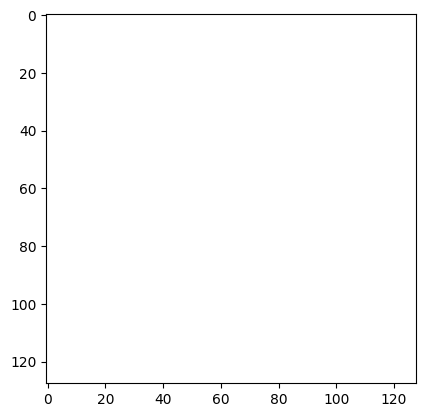

In [ ]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(100):  # Sagital view
    plt.imshow(data[i]["image"][0].T, cmap="bone")
    mask = data[i]["label"][0]
    mask_ = np.ma.masked_where(mask==0, mask)
    plt.imshow(mask_.T, alpha=0.5, cmap="autumn")
    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation
HTML(animation.to_html5_video())  # convert the animation to a video

In [17]:
# Data augmentation

train_transforms = Compose(
    [
            RandAffined(
             keys=['image', 'label'],
             mode=('bilinear', 'nearest'),
             prob=0.2, spatial_size=(128, 128),
             rotate_range=(0, 0, np.pi/15),
             scale_range=(0.1, 0.1, 0.1),
            translate_range=(0.1, 0.1, 0.1),
            padding_mode='border'),
            ToTensord(keys=["image", "label"], dtype=torch.float32),
    ]
)

val_transforms = Compose(
    [
        ToTensord(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [18]:
# check sample from dataset
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

torch.Size([451, 3, 128, 128])
image shape: torch.Size([128, 128]), label shape: torch.Size([128, 128])


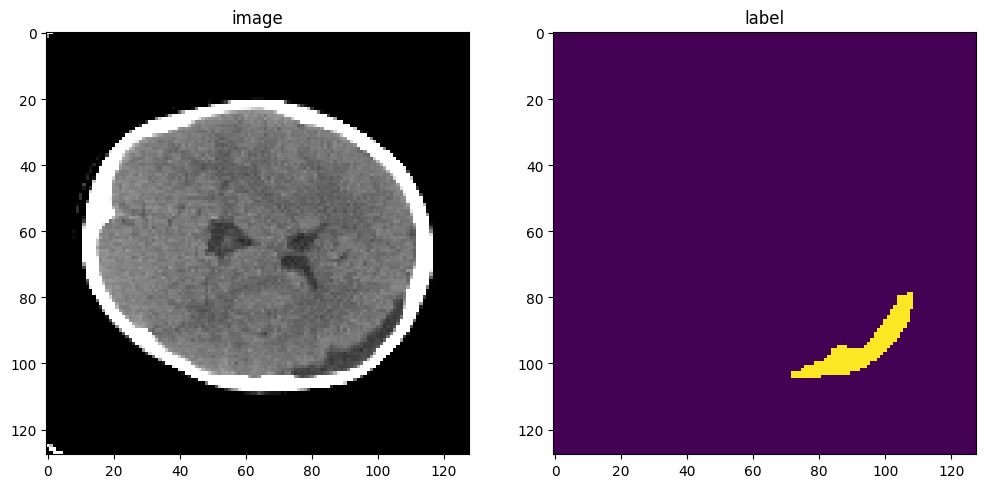

In [22]:
print(check_data["image"].shape)
image, label = (check_data["image"][125][0], check_data["label"][125][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :])
plt.show()

### Training

In [23]:
device = torch.device("cuda:0")
loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)

model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1,
    activation='sigmoid',
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 372MB/s]


In [24]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

num_CV = 5
max_epochs = 600
epoch_per_CV = max_epochs // num_CV

for i in range(num_CV):

    print("-" * 10)
    print(f"Fold {i}")
    train_ds = CacheDataset(data=train_files[i], transform=train_transforms, cache_rate=1.0, num_workers=4)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_ds = CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

    if i < num_CV - 1:
        start_epoch = i * epoch_per_CV
        end_epoch = (i + 1) * epoch_per_CV
    else:
        start_epoch = i * epoch_per_CV
        end_epoch = max_epochs

    for epoch in range(start_epoch, end_epoch):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
        # lr_scheduler.step()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    val_outputs = (val_outputs > 0.5).float()  # Assuming sigmoid activation

                    # Calculate Dice for the batch
                    intersection = torch.sum(val_outputs * val_labels)
                    union = torch.sum(val_outputs) + torch.sum(val_labels) - intersection
                    iou = (intersection + 1e-15) / (union + 1e-15)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
Fold 0


Loading dataset: 100%|██████████| 451/451 [00:00<00:00, 1448.13it/s]


----------
epoch 1/600


Training: 100%|██████████| 57/57 [00:09<00:00,  6.32it/s]


epoch 1 average loss: 0.9625
----------
epoch 2/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.77it/s]


epoch 2 average loss: 0.9970


Validation: 100%|██████████| 57/57 [00:01<00:00, 29.01it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.0011
best mean IoU: 0.0011 at epoch: 2
----------
epoch 3/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 3 average loss: 0.9795
----------
epoch 4/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.96it/s]


epoch 4 average loss: 0.9792


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.31it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.0015
best mean IoU: 0.0015 at epoch: 4
----------
epoch 5/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.82it/s]


epoch 5 average loss: 0.9616
----------
epoch 6/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.97it/s]


epoch 6 average loss: 0.9438


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.90it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.0021
best mean IoU: 0.0021 at epoch: 6
----------
epoch 7/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.67it/s]


epoch 7 average loss: 0.9612
----------
epoch 8/600


Training: 100%|██████████| 57/57 [00:04<00:00, 12.07it/s]


epoch 8 average loss: 0.9786


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.72it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.0030
best mean IoU: 0.0030 at epoch: 8
----------
epoch 9/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.90it/s]


epoch 9 average loss: 0.9782
----------
epoch 10/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.87it/s]


epoch 10 average loss: 0.9783


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.67it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.0038
best mean IoU: 0.0038 at epoch: 10
----------
epoch 11/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.73it/s]


epoch 11 average loss: 0.9429
----------
epoch 12/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.77it/s]


epoch 12 average loss: 0.9603


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.92it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.0051
best mean IoU: 0.0051 at epoch: 12
----------
epoch 13/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.82it/s]


epoch 13 average loss: 0.9776
----------
epoch 14/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 14 average loss: 0.9599


Validation: 100%|██████████| 57/57 [00:01<00:00, 42.41it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.0072
best mean IoU: 0.0072 at epoch: 14
----------
epoch 15/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.78it/s]


epoch 15 average loss: 0.9595
----------
epoch 16/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 16 average loss: 0.9768


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.30it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.0079
best mean IoU: 0.0079 at epoch: 16
----------
epoch 17/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.76it/s]


epoch 17 average loss: 0.9594
----------
epoch 18/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.70it/s]


epoch 18 average loss: 0.9768


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.35it/s]


saved new best metric model
current epoch: 18 current mean IoU: 0.0099
best mean IoU: 0.0099 at epoch: 18
----------
epoch 19/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.71it/s]


epoch 19 average loss: 0.9763
----------
epoch 20/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.80it/s]


epoch 20 average loss: 0.9590


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.20it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.0117
best mean IoU: 0.0117 at epoch: 20
----------
epoch 21/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.79it/s]


epoch 21 average loss: 0.9413
----------
epoch 22/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.83it/s]


epoch 22 average loss: 0.9588


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.54it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.0117
best mean IoU: 0.0117 at epoch: 22
----------
epoch 23/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.63it/s]


epoch 23 average loss: 0.9760
----------
epoch 24/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 24 average loss: 0.9935


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.85it/s]


saved new best metric model
current epoch: 24 current mean IoU: 0.0145
best mean IoU: 0.0145 at epoch: 24
----------
epoch 25/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 25 average loss: 0.9580
----------
epoch 26/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.91it/s]


epoch 26 average loss: 0.9758


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.70it/s]


saved new best metric model
current epoch: 26 current mean IoU: 0.0195
best mean IoU: 0.0195 at epoch: 26
----------
epoch 27/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 27 average loss: 0.9580
----------
epoch 28/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.71it/s]


epoch 28 average loss: 0.9580


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.78it/s]


saved new best metric model
current epoch: 28 current mean IoU: 0.0206
best mean IoU: 0.0206 at epoch: 28
----------
epoch 29/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 29 average loss: 0.9930
----------
epoch 30/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 30 average loss: 0.9753


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.21it/s]


saved new best metric model
current epoch: 30 current mean IoU: 0.0219
best mean IoU: 0.0219 at epoch: 30
----------
epoch 31/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 31 average loss: 0.9226
----------
epoch 32/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 32 average loss: 0.9751


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.95it/s]


saved new best metric model
current epoch: 32 current mean IoU: 0.0229
best mean IoU: 0.0229 at epoch: 32
----------
epoch 33/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.66it/s]


epoch 33 average loss: 0.9572
----------
epoch 34/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 34 average loss: 0.9922


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.97it/s]


saved new best metric model
current epoch: 34 current mean IoU: 0.0246
best mean IoU: 0.0246 at epoch: 34
----------
epoch 35/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.86it/s]


epoch 35 average loss: 0.9572
----------
epoch 36/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.64it/s]


epoch 36 average loss: 0.9392


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.69it/s]


saved new best metric model
current epoch: 36 current mean IoU: 0.0482
best mean IoU: 0.0482 at epoch: 36
----------
epoch 37/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.69it/s]


epoch 37 average loss: 0.9742
----------
epoch 38/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 38 average loss: 0.9565


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.71it/s]


saved new best metric model
current epoch: 38 current mean IoU: 0.1077
best mean IoU: 0.1077 at epoch: 38
----------
epoch 39/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.61it/s]


epoch 39 average loss: 0.9563
----------
epoch 40/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.83it/s]


epoch 40 average loss: 0.9912


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.58it/s]


saved new best metric model
current epoch: 40 current mean IoU: 0.2074
best mean IoU: 0.2074 at epoch: 40
----------
epoch 41/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 41 average loss: 0.9379
----------
epoch 42/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.76it/s]


epoch 42 average loss: 0.9382


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.66it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.2084
best mean IoU: 0.2084 at epoch: 42
----------
epoch 43/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 43 average loss: 0.9907
----------
epoch 44/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 44 average loss: 0.9554


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.15it/s]


saved new best metric model
current epoch: 44 current mean IoU: 0.2651
best mean IoU: 0.2651 at epoch: 44
----------
epoch 45/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 45 average loss: 0.9727
----------
epoch 46/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.75it/s]


epoch 46 average loss: 0.9724


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.45it/s]


current epoch: 46 current mean IoU: 0.2017
best mean IoU: 0.2651 at epoch: 44
----------
epoch 47/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 47 average loss: 0.9549
----------
epoch 48/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.70it/s]


epoch 48 average loss: 0.9546


Validation: 100%|██████████| 57/57 [00:01<00:00, 41.19it/s]


saved new best metric model
current epoch: 48 current mean IoU: 0.2911
best mean IoU: 0.2911 at epoch: 48
----------
epoch 49/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.76it/s]


epoch 49 average loss: 0.9719
----------
epoch 50/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 50 average loss: 0.9535


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.23it/s]


saved new best metric model
current epoch: 50 current mean IoU: 0.3583
best mean IoU: 0.3583 at epoch: 50
----------
epoch 51/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.55it/s]


epoch 51 average loss: 0.9715
----------
epoch 52/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 52 average loss: 0.9535


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.94it/s]


current epoch: 52 current mean IoU: 0.3407
best mean IoU: 0.3583 at epoch: 50
----------
epoch 53/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.64it/s]


epoch 53 average loss: 0.9359
----------
epoch 54/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.61it/s]


epoch 54 average loss: 0.9351


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.33it/s]


current epoch: 54 current mean IoU: 0.3346
best mean IoU: 0.3583 at epoch: 50
----------
epoch 55/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 55 average loss: 0.9528
----------
epoch 56/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 56 average loss: 0.9526


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.04it/s]


saved new best metric model
current epoch: 56 current mean IoU: 0.3597
best mean IoU: 0.3597 at epoch: 56
----------
epoch 57/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 57 average loss: 0.9698
----------
epoch 58/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.71it/s]


epoch 58 average loss: 0.9345


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.69it/s]


saved new best metric model
current epoch: 58 current mean IoU: 0.3797
best mean IoU: 0.3797 at epoch: 58
----------
epoch 59/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 59 average loss: 0.9516
----------
epoch 60/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.66it/s]


epoch 60 average loss: 0.9689


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.82it/s]


current epoch: 60 current mean IoU: 0.2908
best mean IoU: 0.3797 at epoch: 58
----------
epoch 61/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 61 average loss: 0.9337
----------
epoch 62/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 62 average loss: 0.9158


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.95it/s]


current epoch: 62 current mean IoU: 0.3254
best mean IoU: 0.3797 at epoch: 58
----------
epoch 63/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.40it/s]


epoch 63 average loss: 0.9322
----------
epoch 64/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.65it/s]


epoch 64 average loss: 0.9327


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.45it/s]


current epoch: 64 current mean IoU: 0.2713
best mean IoU: 0.3797 at epoch: 58
----------
epoch 65/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.65it/s]


epoch 65 average loss: 0.9325
----------
epoch 66/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 66 average loss: 0.9669


Validation: 100%|██████████| 57/57 [00:01<00:00, 41.44it/s]


current epoch: 66 current mean IoU: 0.3638
best mean IoU: 0.3797 at epoch: 58
----------
epoch 67/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.73it/s]


epoch 67 average loss: 0.9668
----------
epoch 68/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 68 average loss: 0.9304


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.86it/s]


saved new best metric model
current epoch: 68 current mean IoU: 0.3887
best mean IoU: 0.3887 at epoch: 68
----------
epoch 69/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.67it/s]


epoch 69 average loss: 0.9481
----------
epoch 70/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 70 average loss: 0.9475


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.74it/s]


saved new best metric model
current epoch: 70 current mean IoU: 0.4127
best mean IoU: 0.4127 at epoch: 70
----------
epoch 71/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 71 average loss: 0.9649
----------
epoch 72/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.63it/s]


epoch 72 average loss: 0.9297


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.51it/s]


current epoch: 72 current mean IoU: 0.2362
best mean IoU: 0.4127 at epoch: 70
----------
epoch 73/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 73 average loss: 0.9469
----------
epoch 74/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.68it/s]


epoch 74 average loss: 0.9463


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.01it/s]


current epoch: 74 current mean IoU: 0.3727
best mean IoU: 0.4127 at epoch: 70
----------
epoch 75/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 75 average loss: 0.9809
----------
epoch 76/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.69it/s]


epoch 76 average loss: 0.9456


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.78it/s]


saved new best metric model
current epoch: 76 current mean IoU: 0.4139
best mean IoU: 0.4139 at epoch: 76
----------
epoch 77/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 77 average loss: 0.9442
----------
epoch 78/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.52it/s]


epoch 78 average loss: 0.9273


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.06it/s]


current epoch: 78 current mean IoU: 0.3612
best mean IoU: 0.4139 at epoch: 76
----------
epoch 79/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.71it/s]


epoch 79 average loss: 0.9445
----------
epoch 80/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.64it/s]


epoch 80 average loss: 0.9083


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.19it/s]


current epoch: 80 current mean IoU: 0.4075
best mean IoU: 0.4139 at epoch: 76
----------
epoch 81/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.54it/s]


epoch 81 average loss: 0.9077
----------
epoch 82/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 82 average loss: 0.9593


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.47it/s]


current epoch: 82 current mean IoU: 0.3993
best mean IoU: 0.4139 at epoch: 76
----------
epoch 83/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 83 average loss: 0.9409
----------
epoch 84/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 84 average loss: 0.9388


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.51it/s]


current epoch: 84 current mean IoU: 0.4001
best mean IoU: 0.4139 at epoch: 76
----------
epoch 85/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 85 average loss: 0.9393
----------
epoch 86/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 86 average loss: 0.9027


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.53it/s]


current epoch: 86 current mean IoU: 0.3992
best mean IoU: 0.4139 at epoch: 76
----------
epoch 87/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.20it/s]


epoch 87 average loss: 0.9369
----------
epoch 88/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 88 average loss: 0.9355


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.96it/s]


current epoch: 88 current mean IoU: 0.4087
best mean IoU: 0.4139 at epoch: 76
----------
epoch 89/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 89 average loss: 0.9521
----------
epoch 90/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.72it/s]


epoch 90 average loss: 0.8986


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.89it/s]


current epoch: 90 current mean IoU: 0.3973
best mean IoU: 0.4139 at epoch: 76
----------
epoch 91/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 91 average loss: 0.8975
----------
epoch 92/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.67it/s]


epoch 92 average loss: 0.9662


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.05it/s]


current epoch: 92 current mean IoU: 0.3322
best mean IoU: 0.4139 at epoch: 76
----------
epoch 93/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 93 average loss: 0.9305
----------
epoch 94/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


epoch 94 average loss: 0.9466


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.28it/s]


current epoch: 94 current mean IoU: 0.3505
best mean IoU: 0.4139 at epoch: 76
----------
epoch 95/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 95 average loss: 0.9283
----------
epoch 96/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 96 average loss: 0.9265


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.67it/s]


current epoch: 96 current mean IoU: 0.3733
best mean IoU: 0.4139 at epoch: 76
----------
epoch 97/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 97 average loss: 0.9253
----------
epoch 98/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 98 average loss: 0.9238


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.70it/s]


saved new best metric model
current epoch: 98 current mean IoU: 0.4338
best mean IoU: 0.4338 at epoch: 98
----------
epoch 99/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.67it/s]


epoch 99 average loss: 0.9400
----------
epoch 100/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


epoch 100 average loss: 0.8691


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.08it/s]


current epoch: 100 current mean IoU: 0.3921
best mean IoU: 0.4338 at epoch: 98
----------
epoch 101/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.66it/s]


epoch 101 average loss: 0.9196
----------
epoch 102/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 102 average loss: 0.9181


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.75it/s]


current epoch: 102 current mean IoU: 0.4045
best mean IoU: 0.4338 at epoch: 98
----------
epoch 103/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 103 average loss: 0.9171
----------
epoch 104/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.58it/s]


epoch 104 average loss: 0.9323


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.13it/s]


saved new best metric model
current epoch: 104 current mean IoU: 0.4454
best mean IoU: 0.4454 at epoch: 104
----------
epoch 105/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 105 average loss: 0.9304
----------
epoch 106/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.70it/s]


epoch 106 average loss: 0.9108


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.25it/s]


current epoch: 106 current mean IoU: 0.4187
best mean IoU: 0.4454 at epoch: 104
----------
epoch 107/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.52it/s]


epoch 107 average loss: 0.8931
----------
epoch 108/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 108 average loss: 0.9259


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.49it/s]


saved new best metric model
current epoch: 108 current mean IoU: 0.4479
best mean IoU: 0.4479 at epoch: 108
----------
epoch 109/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 109 average loss: 0.9246
----------
epoch 110/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 110 average loss: 0.9401


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.18it/s]


saved new best metric model
current epoch: 110 current mean IoU: 0.4835
best mean IoU: 0.4835 at epoch: 110
----------
epoch 111/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.63it/s]


epoch 111 average loss: 0.9178
----------
epoch 112/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 112 average loss: 0.9163


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.83it/s]


saved new best metric model
current epoch: 112 current mean IoU: 0.4896
best mean IoU: 0.4896 at epoch: 112
----------
epoch 113/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


epoch 113 average loss: 0.8464
----------
epoch 114/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 114 average loss: 0.8960


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.80it/s]


current epoch: 114 current mean IoU: 0.4334
best mean IoU: 0.4896 at epoch: 112
----------
epoch 115/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.74it/s]


epoch 115 average loss: 0.8917
----------
epoch 116/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.55it/s]


epoch 116 average loss: 0.9058


Validation: 100%|██████████| 57/57 [00:01<00:00, 41.03it/s]


saved new best metric model
current epoch: 116 current mean IoU: 0.4935
best mean IoU: 0.4935 at epoch: 116
----------
epoch 117/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.67it/s]


epoch 117 average loss: 0.8702
----------
epoch 118/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 118 average loss: 0.9008


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.34it/s]


current epoch: 118 current mean IoU: 0.4672
best mean IoU: 0.4935 at epoch: 116
----------
epoch 119/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 119 average loss: 0.8969
----------
epoch 120/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 120 average loss: 0.8787


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.95it/s]


current epoch: 120 current mean IoU: 0.4319
best mean IoU: 0.4935 at epoch: 116
----------
Fold 1


Loading dataset: 100%|██████████| 451/451 [00:00<00:00, 1382.88it/s]


----------
epoch 121/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 121 average loss: 0.9112
----------
epoch 122/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 122 average loss: 0.8877


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.07it/s]


saved new best metric model
current epoch: 122 current mean IoU: 0.5593
best mean IoU: 0.5593 at epoch: 122
----------
epoch 123/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 123 average loss: 0.8691
----------
epoch 124/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.52it/s]


epoch 124 average loss: 0.8614


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.18it/s]


saved new best metric model
current epoch: 124 current mean IoU: 0.6101
best mean IoU: 0.6101 at epoch: 124
----------
epoch 125/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 125 average loss: 0.8778
----------
epoch 126/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 126 average loss: 0.8941


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.40it/s]


current epoch: 126 current mean IoU: 0.5652
best mean IoU: 0.6101 at epoch: 124
----------
epoch 127/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.52it/s]


epoch 127 average loss: 0.8520
----------
epoch 128/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.70it/s]


epoch 128 average loss: 0.8474


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.90it/s]


current epoch: 128 current mean IoU: 0.5956
best mean IoU: 0.6101 at epoch: 124
----------
epoch 129/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 129 average loss: 0.8545
----------
epoch 130/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 130 average loss: 0.8380


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.47it/s]


current epoch: 130 current mean IoU: 0.5155
best mean IoU: 0.6101 at epoch: 124
----------
epoch 131/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 131 average loss: 0.8195
----------
epoch 132/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 132 average loss: 0.8493


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.92it/s]


current epoch: 132 current mean IoU: 0.6069
best mean IoU: 0.6101 at epoch: 124
----------
epoch 133/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 133 average loss: 0.8234
----------
epoch 134/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 134 average loss: 0.8397


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.22it/s]


saved new best metric model
current epoch: 134 current mean IoU: 0.6199
best mean IoU: 0.6199 at epoch: 134
----------
epoch 135/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 135 average loss: 0.8287
----------
epoch 136/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.17it/s]


epoch 136 average loss: 0.8456


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.45it/s]


saved new best metric model
current epoch: 136 current mean IoU: 0.6484
best mean IoU: 0.6484 at epoch: 136
----------
epoch 137/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.66it/s]


epoch 137 average loss: 0.7929
----------
epoch 138/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 138 average loss: 0.7834


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.92it/s]


saved new best metric model
current epoch: 138 current mean IoU: 0.6846
best mean IoU: 0.6846 at epoch: 138
----------
epoch 139/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


epoch 139 average loss: 0.7993
----------
epoch 140/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 140 average loss: 0.8033


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.27it/s]


current epoch: 140 current mean IoU: 0.6633
best mean IoU: 0.6846 at epoch: 138
----------
epoch 141/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 141 average loss: 0.8189
----------
epoch 142/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.65it/s]


epoch 142 average loss: 0.8041


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.95it/s]


current epoch: 142 current mean IoU: 0.6593
best mean IoU: 0.6846 at epoch: 138
----------
epoch 143/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 143 average loss: 0.8025
----------
epoch 144/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.58it/s]


epoch 144 average loss: 0.7835


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.96it/s]


current epoch: 144 current mean IoU: 0.6484
best mean IoU: 0.6846 at epoch: 138
----------
epoch 145/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 145 average loss: 0.7934
----------
epoch 146/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.55it/s]


epoch 146 average loss: 0.7603


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.31it/s]


current epoch: 146 current mean IoU: 0.6441
best mean IoU: 0.6846 at epoch: 138
----------
epoch 147/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 147 average loss: 0.7642
----------
epoch 148/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 148 average loss: 0.7679


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.26it/s]


current epoch: 148 current mean IoU: 0.6369
best mean IoU: 0.6846 at epoch: 138
----------
epoch 149/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.63it/s]


epoch 149 average loss: 0.7181
----------
epoch 150/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 150 average loss: 0.7273


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.32it/s]


current epoch: 150 current mean IoU: 0.6603
best mean IoU: 0.6846 at epoch: 138
----------
epoch 151/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.65it/s]


epoch 151 average loss: 0.7514
----------
epoch 152/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 152 average loss: 0.7444


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.94it/s]


current epoch: 152 current mean IoU: 0.6742
best mean IoU: 0.6846 at epoch: 138
----------
epoch 153/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 153 average loss: 0.7351
----------
epoch 154/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 154 average loss: 0.7317


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.26it/s]


saved new best metric model
current epoch: 154 current mean IoU: 0.6855
best mean IoU: 0.6855 at epoch: 154
----------
epoch 155/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 155 average loss: 0.6958
----------
epoch 156/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 156 average loss: 0.7293


Validation: 100%|██████████| 57/57 [00:01<00:00, 32.97it/s]


current epoch: 156 current mean IoU: 0.6707
best mean IoU: 0.6855 at epoch: 154
----------
epoch 157/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 157 average loss: 0.6925
----------
epoch 158/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 158 average loss: 0.6283


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.11it/s]


current epoch: 158 current mean IoU: 0.6565
best mean IoU: 0.6855 at epoch: 154
----------
epoch 159/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 159 average loss: 0.7135
----------
epoch 160/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.69it/s]


epoch 160 average loss: 0.6778


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.97it/s]


saved new best metric model
current epoch: 160 current mean IoU: 0.6923
best mean IoU: 0.6923 at epoch: 160
----------
epoch 161/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 161 average loss: 0.6905
----------
epoch 162/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 162 average loss: 0.6822


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.65it/s]


current epoch: 162 current mean IoU: 0.6695
best mean IoU: 0.6923 at epoch: 160
----------
epoch 163/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 163 average loss: 0.6713
----------
epoch 164/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 164 average loss: 0.6141


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.95it/s]


saved new best metric model
current epoch: 164 current mean IoU: 0.7179
best mean IoU: 0.7179 at epoch: 164
----------
epoch 165/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 165 average loss: 0.6555
----------
epoch 166/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 166 average loss: 0.6368


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.39it/s]


saved new best metric model
current epoch: 166 current mean IoU: 0.7235
best mean IoU: 0.7235 at epoch: 166
----------
epoch 167/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.63it/s]


epoch 167 average loss: 0.6522
----------
epoch 168/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 168 average loss: 0.5966


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.16it/s]


current epoch: 168 current mean IoU: 0.6925
best mean IoU: 0.7235 at epoch: 166
----------
epoch 169/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 169 average loss: 0.6087
----------
epoch 170/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 170 average loss: 0.6228


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.89it/s]


current epoch: 170 current mean IoU: 0.7176
best mean IoU: 0.7235 at epoch: 166
----------
epoch 171/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 171 average loss: 0.5685
----------
epoch 172/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 172 average loss: 0.5793


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.11it/s]


current epoch: 172 current mean IoU: 0.7161
best mean IoU: 0.7235 at epoch: 166
----------
epoch 173/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 173 average loss: 0.5792
----------
epoch 174/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 174 average loss: 0.5849


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.86it/s]


current epoch: 174 current mean IoU: 0.7150
best mean IoU: 0.7235 at epoch: 166
----------
epoch 175/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 175 average loss: 0.5421
----------
epoch 176/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 176 average loss: 0.5296


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.55it/s]


current epoch: 176 current mean IoU: 0.7139
best mean IoU: 0.7235 at epoch: 166
----------
epoch 177/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 177 average loss: 0.5269
----------
epoch 178/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 178 average loss: 0.5340


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.92it/s]


current epoch: 178 current mean IoU: 0.6948
best mean IoU: 0.7235 at epoch: 166
----------
epoch 179/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 179 average loss: 0.4965
----------
epoch 180/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 180 average loss: 0.5420


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.51it/s]


current epoch: 180 current mean IoU: 0.7123
best mean IoU: 0.7235 at epoch: 166
----------
epoch 181/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 181 average loss: 0.5089
----------
epoch 182/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 182 average loss: 0.5133


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.98it/s]


current epoch: 182 current mean IoU: 0.6963
best mean IoU: 0.7235 at epoch: 166
----------
epoch 183/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 183 average loss: 0.5042
----------
epoch 184/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 184 average loss: 0.5271


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.86it/s]


current epoch: 184 current mean IoU: 0.6920
best mean IoU: 0.7235 at epoch: 166
----------
epoch 185/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 185 average loss: 0.5046
----------
epoch 186/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 186 average loss: 0.4792


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.44it/s]


current epoch: 186 current mean IoU: 0.6898
best mean IoU: 0.7235 at epoch: 166
----------
epoch 187/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.61it/s]


epoch 187 average loss: 0.4868
----------
epoch 188/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 188 average loss: 0.4688


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.24it/s]


current epoch: 188 current mean IoU: 0.7204
best mean IoU: 0.7235 at epoch: 166
----------
epoch 189/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 189 average loss: 0.4494
----------
epoch 190/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 190 average loss: 0.4627


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.23it/s]


current epoch: 190 current mean IoU: 0.7225
best mean IoU: 0.7235 at epoch: 166
----------
epoch 191/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 191 average loss: 0.4165
----------
epoch 192/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 192 average loss: 0.4480


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.89it/s]


current epoch: 192 current mean IoU: 0.7162
best mean IoU: 0.7235 at epoch: 166
----------
epoch 193/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 193 average loss: 0.4575
----------
epoch 194/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 194 average loss: 0.4076


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.46it/s]


current epoch: 194 current mean IoU: 0.7106
best mean IoU: 0.7235 at epoch: 166
----------
epoch 195/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 195 average loss: 0.4097
----------
epoch 196/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 196 average loss: 0.3953


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.63it/s]


current epoch: 196 current mean IoU: 0.7149
best mean IoU: 0.7235 at epoch: 166
----------
epoch 197/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 197 average loss: 0.4006
----------
epoch 198/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 198 average loss: 0.3862


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.62it/s]


current epoch: 198 current mean IoU: 0.7158
best mean IoU: 0.7235 at epoch: 166
----------
epoch 199/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 199 average loss: 0.3923
----------
epoch 200/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 200 average loss: 0.4235


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.58it/s]


current epoch: 200 current mean IoU: 0.7163
best mean IoU: 0.7235 at epoch: 166
----------
epoch 201/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 201 average loss: 0.3902
----------
epoch 202/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 202 average loss: 0.3946


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.33it/s]


current epoch: 202 current mean IoU: 0.7042
best mean IoU: 0.7235 at epoch: 166
----------
epoch 203/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 203 average loss: 0.3454
----------
epoch 204/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 204 average loss: 0.3914


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.47it/s]


current epoch: 204 current mean IoU: 0.7090
best mean IoU: 0.7235 at epoch: 166
----------
epoch 205/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 205 average loss: 0.3605
----------
epoch 206/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.66it/s]


epoch 206 average loss: 0.3572


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.31it/s]


current epoch: 206 current mean IoU: 0.7229
best mean IoU: 0.7235 at epoch: 166
----------
epoch 207/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 207 average loss: 0.3512
----------
epoch 208/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


epoch 208 average loss: 0.3393


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.66it/s]


current epoch: 208 current mean IoU: 0.7176
best mean IoU: 0.7235 at epoch: 166
----------
epoch 209/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


epoch 209 average loss: 0.3499
----------
epoch 210/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 210 average loss: 0.3103


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.12it/s]


current epoch: 210 current mean IoU: 0.7021
best mean IoU: 0.7235 at epoch: 166
----------
epoch 211/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 211 average loss: 0.3380
----------
epoch 212/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 212 average loss: 0.3704


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.54it/s]


current epoch: 212 current mean IoU: 0.7051
best mean IoU: 0.7235 at epoch: 166
----------
epoch 213/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 213 average loss: 0.3289
----------
epoch 214/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.07it/s]


epoch 214 average loss: 0.3443


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.25it/s]


current epoch: 214 current mean IoU: 0.7053
best mean IoU: 0.7235 at epoch: 166
----------
epoch 215/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 215 average loss: 0.3023
----------
epoch 216/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 216 average loss: 0.3361


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.56it/s]


current epoch: 216 current mean IoU: 0.7201
best mean IoU: 0.7235 at epoch: 166
----------
epoch 217/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.58it/s]


epoch 217 average loss: 0.3117
----------
epoch 218/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 218 average loss: 0.3220


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.27it/s]


current epoch: 218 current mean IoU: 0.7123
best mean IoU: 0.7235 at epoch: 166
----------
epoch 219/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 219 average loss: 0.3113
----------
epoch 220/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 220 average loss: 0.3018


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.24it/s]


current epoch: 220 current mean IoU: 0.7021
best mean IoU: 0.7235 at epoch: 166
----------
epoch 221/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 221 average loss: 0.2631
----------
epoch 222/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 222 average loss: 0.2774


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.51it/s]


current epoch: 222 current mean IoU: 0.7168
best mean IoU: 0.7235 at epoch: 166
----------
epoch 223/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 223 average loss: 0.2856
----------
epoch 224/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


epoch 224 average loss: 0.2907


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.43it/s]


current epoch: 224 current mean IoU: 0.7061
best mean IoU: 0.7235 at epoch: 166
----------
epoch 225/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 225 average loss: 0.2683
----------
epoch 226/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.62it/s]


epoch 226 average loss: 0.2844


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.49it/s]


current epoch: 226 current mean IoU: 0.6213
best mean IoU: 0.7235 at epoch: 166
----------
epoch 227/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 227 average loss: 0.2664
----------
epoch 228/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 228 average loss: 0.2641


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.05it/s]


current epoch: 228 current mean IoU: 0.7042
best mean IoU: 0.7235 at epoch: 166
----------
epoch 229/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 229 average loss: 0.2726
----------
epoch 230/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.17it/s]


epoch 230 average loss: 0.2710


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.96it/s]


current epoch: 230 current mean IoU: 0.7194
best mean IoU: 0.7235 at epoch: 166
----------
epoch 231/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 231 average loss: 0.2452
----------
epoch 232/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 232 average loss: 0.2717


Validation: 100%|██████████| 57/57 [00:01<00:00, 40.40it/s]


current epoch: 232 current mean IoU: 0.6841
best mean IoU: 0.7235 at epoch: 166
----------
epoch 233/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 233 average loss: 0.2345
----------
epoch 234/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 234 average loss: 0.2574


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.59it/s]


saved new best metric model
current epoch: 234 current mean IoU: 0.7254
best mean IoU: 0.7254 at epoch: 234
----------
epoch 235/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.55it/s]


epoch 235 average loss: 0.2275
----------
epoch 236/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 236 average loss: 0.2181


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.55it/s]


current epoch: 236 current mean IoU: 0.7198
best mean IoU: 0.7254 at epoch: 234
----------
epoch 237/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 237 average loss: 0.2506
----------
epoch 238/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 238 average loss: 0.2194


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.42it/s]


current epoch: 238 current mean IoU: 0.7219
best mean IoU: 0.7254 at epoch: 234
----------
epoch 239/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 239 average loss: 0.2269
----------
epoch 240/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 240 average loss: 0.2608


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.99it/s]


current epoch: 240 current mean IoU: 0.7150
best mean IoU: 0.7254 at epoch: 234
----------
Fold 2


Loading dataset: 100%|██████████| 450/450 [00:00<00:00, 1367.91it/s]


----------
epoch 241/600


Training: 100%|██████████| 57/57 [00:05<00:00,  9.97it/s]


epoch 241 average loss: 0.2494
----------
epoch 242/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.40it/s]


epoch 242 average loss: 0.2394


Validation: 100%|██████████| 57/57 [00:01<00:00, 33.91it/s]


saved new best metric model
current epoch: 242 current mean IoU: 0.8802
best mean IoU: 0.8802 at epoch: 242
----------
epoch 243/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 243 average loss: 0.2166
----------
epoch 244/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 244 average loss: 0.2409


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.08it/s]


saved new best metric model
current epoch: 244 current mean IoU: 0.8850
best mean IoU: 0.8850 at epoch: 244
----------
epoch 245/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 245 average loss: 0.2245
----------
epoch 246/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 246 average loss: 0.2343


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.79it/s]


current epoch: 246 current mean IoU: 0.8556
best mean IoU: 0.8850 at epoch: 244
----------
epoch 247/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.18it/s]


epoch 247 average loss: 0.2250
----------
epoch 248/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 248 average loss: 0.2145


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.88it/s]


current epoch: 248 current mean IoU: 0.8741
best mean IoU: 0.8850 at epoch: 244
----------
epoch 249/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 249 average loss: 0.2304
----------
epoch 250/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 250 average loss: 0.2409


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.76it/s]


current epoch: 250 current mean IoU: 0.8809
best mean IoU: 0.8850 at epoch: 244
----------
epoch 251/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 251 average loss: 0.1997
----------
epoch 252/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 252 average loss: 0.2170


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.89it/s]


current epoch: 252 current mean IoU: 0.8805
best mean IoU: 0.8850 at epoch: 244
----------
epoch 253/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 253 average loss: 0.2078
----------
epoch 254/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 254 average loss: 0.2011


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.87it/s]


current epoch: 254 current mean IoU: 0.8826
best mean IoU: 0.8850 at epoch: 244
----------
epoch 255/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 255 average loss: 0.1990
----------
epoch 256/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 256 average loss: 0.1976


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.00it/s]


current epoch: 256 current mean IoU: 0.8733
best mean IoU: 0.8850 at epoch: 244
----------
epoch 257/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 257 average loss: 0.1891
----------
epoch 258/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 258 average loss: 0.1912


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.70it/s]


current epoch: 258 current mean IoU: 0.8811
best mean IoU: 0.8850 at epoch: 244
----------
epoch 259/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 259 average loss: 0.2061
----------
epoch 260/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 260 average loss: 0.1940


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.09it/s]


saved new best metric model
current epoch: 260 current mean IoU: 0.8852
best mean IoU: 0.8852 at epoch: 260
----------
epoch 261/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.99it/s]


epoch 261 average loss: 0.2115
----------
epoch 262/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 262 average loss: 0.1998


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.92it/s]


current epoch: 262 current mean IoU: 0.8824
best mean IoU: 0.8852 at epoch: 260
----------
epoch 263/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 263 average loss: 0.1896
----------
epoch 264/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 264 average loss: 0.1987


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.55it/s]


saved new best metric model
current epoch: 264 current mean IoU: 0.8865
best mean IoU: 0.8865 at epoch: 264
----------
epoch 265/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 265 average loss: 0.2111
----------
epoch 266/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 266 average loss: 0.1893


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.25it/s]


current epoch: 266 current mean IoU: 0.8757
best mean IoU: 0.8865 at epoch: 264
----------
epoch 267/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 267 average loss: 0.2074
----------
epoch 268/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.20it/s]


epoch 268 average loss: 0.1722


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.84it/s]


current epoch: 268 current mean IoU: 0.8779
best mean IoU: 0.8865 at epoch: 264
----------
epoch 269/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 269 average loss: 0.1689
----------
epoch 270/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 270 average loss: 0.1762


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.03it/s]


current epoch: 270 current mean IoU: 0.8742
best mean IoU: 0.8865 at epoch: 264
----------
epoch 271/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 271 average loss: 0.1542
----------
epoch 272/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 272 average loss: 0.1678


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.11it/s]


current epoch: 272 current mean IoU: 0.8844
best mean IoU: 0.8865 at epoch: 264
----------
epoch 273/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 273 average loss: 0.1825
----------
epoch 274/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.20it/s]


epoch 274 average loss: 0.1832


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.97it/s]


current epoch: 274 current mean IoU: 0.8681
best mean IoU: 0.8865 at epoch: 264
----------
epoch 275/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 275 average loss: 0.1934
----------
epoch 276/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 276 average loss: 0.1584


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.24it/s]


current epoch: 276 current mean IoU: 0.8725
best mean IoU: 0.8865 at epoch: 264
----------
epoch 277/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 277 average loss: 0.1765
----------
epoch 278/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 278 average loss: 0.1698


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.22it/s]


current epoch: 278 current mean IoU: 0.8654
best mean IoU: 0.8865 at epoch: 264
----------
epoch 279/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 279 average loss: 0.1805
----------
epoch 280/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 280 average loss: 0.1510


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.76it/s]


current epoch: 280 current mean IoU: 0.8752
best mean IoU: 0.8865 at epoch: 264
----------
epoch 281/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 281 average loss: 0.1633
----------
epoch 282/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 282 average loss: 0.1544


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.25it/s]


current epoch: 282 current mean IoU: 0.8815
best mean IoU: 0.8865 at epoch: 264
----------
epoch 283/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.13it/s]


epoch 283 average loss: 0.1490
----------
epoch 284/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 284 average loss: 0.1454


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.14it/s]


current epoch: 284 current mean IoU: 0.8723
best mean IoU: 0.8865 at epoch: 264
----------
epoch 285/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 285 average loss: 0.1585
----------
epoch 286/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 286 average loss: 0.1477


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.39it/s]


current epoch: 286 current mean IoU: 0.8772
best mean IoU: 0.8865 at epoch: 264
----------
epoch 287/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 287 average loss: 0.1630
----------
epoch 288/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.21it/s]


epoch 288 average loss: 0.1429


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.60it/s]


current epoch: 288 current mean IoU: 0.8680
best mean IoU: 0.8865 at epoch: 264
----------
epoch 289/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 289 average loss: 0.1459
----------
epoch 290/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 290 average loss: 0.1600


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.94it/s]


current epoch: 290 current mean IoU: 0.8632
best mean IoU: 0.8865 at epoch: 264
----------
epoch 291/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 291 average loss: 0.1676
----------
epoch 292/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 292 average loss: 0.1488


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.39it/s]


current epoch: 292 current mean IoU: 0.8725
best mean IoU: 0.8865 at epoch: 264
----------
epoch 293/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 293 average loss: 0.1618
----------
epoch 294/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.20it/s]


epoch 294 average loss: 0.1589


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.76it/s]


current epoch: 294 current mean IoU: 0.8682
best mean IoU: 0.8865 at epoch: 264
----------
epoch 295/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 295 average loss: 0.1557
----------
epoch 296/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 296 average loss: 0.1524


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.81it/s]


current epoch: 296 current mean IoU: 0.8759
best mean IoU: 0.8865 at epoch: 264
----------
epoch 297/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 297 average loss: 0.1403
----------
epoch 298/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 298 average loss: 0.1285


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.62it/s]


current epoch: 298 current mean IoU: 0.8769
best mean IoU: 0.8865 at epoch: 264
----------
epoch 299/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 299 average loss: 0.1324
----------
epoch 300/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 300 average loss: 0.1244


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.12it/s]


current epoch: 300 current mean IoU: 0.8720
best mean IoU: 0.8865 at epoch: 264
----------
epoch 301/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 301 average loss: 0.1183
----------
epoch 302/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 302 average loss: 0.1273


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.13it/s]


current epoch: 302 current mean IoU: 0.8718
best mean IoU: 0.8865 at epoch: 264
----------
epoch 303/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 303 average loss: 0.1326
----------
epoch 304/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 304 average loss: 0.1198


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.04it/s]


current epoch: 304 current mean IoU: 0.8716
best mean IoU: 0.8865 at epoch: 264
----------
epoch 305/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 305 average loss: 0.1419
----------
epoch 306/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 306 average loss: 0.1333


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.59it/s]


current epoch: 306 current mean IoU: 0.8605
best mean IoU: 0.8865 at epoch: 264
----------
epoch 307/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 307 average loss: 0.1262
----------
epoch 308/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.08it/s]


epoch 308 average loss: 0.1636


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.23it/s]


current epoch: 308 current mean IoU: 0.8570
best mean IoU: 0.8865 at epoch: 264
----------
epoch 309/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 309 average loss: 0.1459
----------
epoch 310/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 310 average loss: 0.1411


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.72it/s]


current epoch: 310 current mean IoU: 0.8663
best mean IoU: 0.8865 at epoch: 264
----------
epoch 311/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 311 average loss: 0.1277
----------
epoch 312/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 312 average loss: 0.1305


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.27it/s]


current epoch: 312 current mean IoU: 0.8623
best mean IoU: 0.8865 at epoch: 264
----------
epoch 313/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 313 average loss: 0.1472
----------
epoch 314/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.40it/s]


epoch 314 average loss: 0.1498


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.69it/s]


current epoch: 314 current mean IoU: 0.8686
best mean IoU: 0.8865 at epoch: 264
----------
epoch 315/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 315 average loss: 0.1300
----------
epoch 316/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.40it/s]


epoch 316 average loss: 0.1230


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.20it/s]


current epoch: 316 current mean IoU: 0.8677
best mean IoU: 0.8865 at epoch: 264
----------
epoch 317/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 317 average loss: 0.1084
----------
epoch 318/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 318 average loss: 0.1203


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.21it/s]


current epoch: 318 current mean IoU: 0.8584
best mean IoU: 0.8865 at epoch: 264
----------
epoch 319/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.14it/s]


epoch 319 average loss: 0.1420
----------
epoch 320/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 320 average loss: 0.1295


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.64it/s]


current epoch: 320 current mean IoU: 0.8630
best mean IoU: 0.8865 at epoch: 264
----------
epoch 321/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 321 average loss: 0.1151
----------
epoch 322/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 322 average loss: 0.1172


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.06it/s]


current epoch: 322 current mean IoU: 0.8617
best mean IoU: 0.8865 at epoch: 264
----------
epoch 323/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.10it/s]


epoch 323 average loss: 0.1120
----------
epoch 324/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.20it/s]


epoch 324 average loss: 0.1239


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.72it/s]


current epoch: 324 current mean IoU: 0.8524
best mean IoU: 0.8865 at epoch: 264
----------
epoch 325/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 325 average loss: 0.1163
----------
epoch 326/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 326 average loss: 0.1244


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.65it/s]


current epoch: 326 current mean IoU: 0.8396
best mean IoU: 0.8865 at epoch: 264
----------
epoch 327/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 327 average loss: 0.1214
----------
epoch 328/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 328 average loss: 0.1205


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.51it/s]


current epoch: 328 current mean IoU: 0.8644
best mean IoU: 0.8865 at epoch: 264
----------
epoch 329/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 329 average loss: 0.1224
----------
epoch 330/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 330 average loss: 0.1277


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.10it/s]


current epoch: 330 current mean IoU: 0.8592
best mean IoU: 0.8865 at epoch: 264
----------
epoch 331/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 331 average loss: 0.1258
----------
epoch 332/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.15it/s]


epoch 332 average loss: 0.1264


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.70it/s]


current epoch: 332 current mean IoU: 0.8621
best mean IoU: 0.8865 at epoch: 264
----------
epoch 333/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 333 average loss: 0.1162
----------
epoch 334/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 334 average loss: 0.1147


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.17it/s]


current epoch: 334 current mean IoU: 0.8552
best mean IoU: 0.8865 at epoch: 264
----------
epoch 335/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.03it/s]


epoch 335 average loss: 0.1143
----------
epoch 336/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 336 average loss: 0.1276


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.79it/s]


current epoch: 336 current mean IoU: 0.8568
best mean IoU: 0.8865 at epoch: 264
----------
epoch 337/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.32it/s]


epoch 337 average loss: 0.1065
----------
epoch 338/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 338 average loss: 0.1432


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.61it/s]


current epoch: 338 current mean IoU: 0.8549
best mean IoU: 0.8865 at epoch: 264
----------
epoch 339/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 339 average loss: 0.1233
----------
epoch 340/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.17it/s]


epoch 340 average loss: 0.1122


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.71it/s]


current epoch: 340 current mean IoU: 0.8508
best mean IoU: 0.8865 at epoch: 264
----------
epoch 341/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 341 average loss: 0.0974
----------
epoch 342/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 342 average loss: 0.0997


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.28it/s]


current epoch: 342 current mean IoU: 0.8636
best mean IoU: 0.8865 at epoch: 264
----------
epoch 343/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 343 average loss: 0.0963
----------
epoch 344/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 344 average loss: 0.1151


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.15it/s]


current epoch: 344 current mean IoU: 0.8517
best mean IoU: 0.8865 at epoch: 264
----------
epoch 345/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 345 average loss: 0.1214
----------
epoch 346/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.11it/s]


epoch 346 average loss: 0.0881


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.45it/s]


current epoch: 346 current mean IoU: 0.8588
best mean IoU: 0.8865 at epoch: 264
----------
epoch 347/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 347 average loss: 0.1070
----------
epoch 348/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 348 average loss: 0.1079


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.09it/s]


current epoch: 348 current mean IoU: 0.8588
best mean IoU: 0.8865 at epoch: 264
----------
epoch 349/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 349 average loss: 0.1053
----------
epoch 350/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 350 average loss: 0.1106


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.83it/s]


current epoch: 350 current mean IoU: 0.8417
best mean IoU: 0.8865 at epoch: 264
----------
epoch 351/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 351 average loss: 0.1056
----------
epoch 352/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 352 average loss: 0.1082


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.86it/s]


current epoch: 352 current mean IoU: 0.8361
best mean IoU: 0.8865 at epoch: 264
----------
epoch 353/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.97it/s]


epoch 353 average loss: 0.1099
----------
epoch 354/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.59it/s]


epoch 354 average loss: 0.0992


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.22it/s]


current epoch: 354 current mean IoU: 0.8492
best mean IoU: 0.8865 at epoch: 264
----------
epoch 355/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.98it/s]


epoch 355 average loss: 0.1185
----------
epoch 356/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 356 average loss: 0.1039


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.67it/s]


current epoch: 356 current mean IoU: 0.8461
best mean IoU: 0.8865 at epoch: 264
----------
epoch 357/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.15it/s]


epoch 357 average loss: 0.0909
----------
epoch 358/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 358 average loss: 0.1098


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.46it/s]


current epoch: 358 current mean IoU: 0.8399
best mean IoU: 0.8865 at epoch: 264
----------
epoch 359/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 359 average loss: 0.0971
----------
epoch 360/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 360 average loss: 0.1003


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.34it/s]


current epoch: 360 current mean IoU: 0.8489
best mean IoU: 0.8865 at epoch: 264
----------
Fold 3


Loading dataset: 100%|██████████| 450/450 [00:00<00:00, 1417.33it/s]


----------
epoch 361/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 361 average loss: 0.1017
----------
epoch 362/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 362 average loss: 0.1195


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.44it/s]


saved new best metric model
current epoch: 362 current mean IoU: 0.8993
best mean IoU: 0.8993 at epoch: 362
----------
epoch 363/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 363 average loss: 0.1002
----------
epoch 364/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 364 average loss: 0.1042


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.63it/s]


current epoch: 364 current mean IoU: 0.8833
best mean IoU: 0.8993 at epoch: 362
----------
epoch 365/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 365 average loss: 0.1196
----------
epoch 366/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 366 average loss: 0.1217


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.88it/s]


current epoch: 366 current mean IoU: 0.8651
best mean IoU: 0.8993 at epoch: 362
----------
epoch 367/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 367 average loss: 0.0985
----------
epoch 368/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 368 average loss: 0.1196


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.79it/s]


current epoch: 368 current mean IoU: 0.8783
best mean IoU: 0.8993 at epoch: 362
----------
epoch 369/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 369 average loss: 0.1111
----------
epoch 370/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 370 average loss: 0.1143


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.30it/s]


current epoch: 370 current mean IoU: 0.8737
best mean IoU: 0.8993 at epoch: 362
----------
epoch 371/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 371 average loss: 0.1006
----------
epoch 372/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.63it/s]


epoch 372 average loss: 0.1352


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.03it/s]


current epoch: 372 current mean IoU: 0.8757
best mean IoU: 0.8993 at epoch: 362
----------
epoch 373/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 373 average loss: 0.1050
----------
epoch 374/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 374 average loss: 0.0994


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.75it/s]


current epoch: 374 current mean IoU: 0.8744
best mean IoU: 0.8993 at epoch: 362
----------
epoch 375/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 375 average loss: 0.1251
----------
epoch 376/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 376 average loss: 0.0928


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.54it/s]


current epoch: 376 current mean IoU: 0.8757
best mean IoU: 0.8993 at epoch: 362
----------
epoch 377/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 377 average loss: 0.1054
----------
epoch 378/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 378 average loss: 0.0948


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.54it/s]


current epoch: 378 current mean IoU: 0.8782
best mean IoU: 0.8993 at epoch: 362
----------
epoch 379/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 379 average loss: 0.0907
----------
epoch 380/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 380 average loss: 0.1074


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.75it/s]


current epoch: 380 current mean IoU: 0.8816
best mean IoU: 0.8993 at epoch: 362
----------
epoch 381/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.66it/s]


epoch 381 average loss: 0.0968
----------
epoch 382/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 382 average loss: 0.1217


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.90it/s]


current epoch: 382 current mean IoU: 0.8703
best mean IoU: 0.8993 at epoch: 362
----------
epoch 383/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.61it/s]


epoch 383 average loss: 0.0914
----------
epoch 384/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.20it/s]


epoch 384 average loss: 0.1040


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.42it/s]


current epoch: 384 current mean IoU: 0.8790
best mean IoU: 0.8993 at epoch: 362
----------
epoch 385/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 385 average loss: 0.0888
----------
epoch 386/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 386 average loss: 0.0918


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.13it/s]


current epoch: 386 current mean IoU: 0.8817
best mean IoU: 0.8993 at epoch: 362
----------
epoch 387/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 387 average loss: 0.0907
----------
epoch 388/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 388 average loss: 0.0898


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.65it/s]


current epoch: 388 current mean IoU: 0.8806
best mean IoU: 0.8993 at epoch: 362
----------
epoch 389/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.20it/s]


epoch 389 average loss: 0.0946
----------
epoch 390/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 390 average loss: 0.0885


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.16it/s]


current epoch: 390 current mean IoU: 0.8775
best mean IoU: 0.8993 at epoch: 362
----------
epoch 391/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 391 average loss: 0.0928
----------
epoch 392/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 392 average loss: 0.0910


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.66it/s]


current epoch: 392 current mean IoU: 0.8766
best mean IoU: 0.8993 at epoch: 362
----------
epoch 393/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.18it/s]


epoch 393 average loss: 0.0940
----------
epoch 394/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 394 average loss: 0.1062


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.16it/s]


current epoch: 394 current mean IoU: 0.8606
best mean IoU: 0.8993 at epoch: 362
----------
epoch 395/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 395 average loss: 0.1109
----------
epoch 396/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 396 average loss: 0.1087


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.50it/s]


current epoch: 396 current mean IoU: 0.8564
best mean IoU: 0.8993 at epoch: 362
----------
epoch 397/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 397 average loss: 0.1098
----------
epoch 398/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 398 average loss: 0.0819


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.59it/s]


current epoch: 398 current mean IoU: 0.8640
best mean IoU: 0.8993 at epoch: 362
----------
epoch 399/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 399 average loss: 0.1022
----------
epoch 400/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.07it/s]


epoch 400 average loss: 0.0904


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.42it/s]


current epoch: 400 current mean IoU: 0.8630
best mean IoU: 0.8993 at epoch: 362
----------
epoch 401/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 401 average loss: 0.0926
----------
epoch 402/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 402 average loss: 0.0926


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.65it/s]


current epoch: 402 current mean IoU: 0.8602
best mean IoU: 0.8993 at epoch: 362
----------
epoch 403/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 403 average loss: 0.1096
----------
epoch 404/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 404 average loss: 0.1131


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.17it/s]


current epoch: 404 current mean IoU: 0.8665
best mean IoU: 0.8993 at epoch: 362
----------
epoch 405/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 405 average loss: 0.0977
----------
epoch 406/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 406 average loss: 0.0931


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.12it/s]


current epoch: 406 current mean IoU: 0.8713
best mean IoU: 0.8993 at epoch: 362
----------
epoch 407/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 407 average loss: 0.0922
----------
epoch 408/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 408 average loss: 0.0929


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.37it/s]


current epoch: 408 current mean IoU: 0.8699
best mean IoU: 0.8993 at epoch: 362
----------
epoch 409/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 409 average loss: 0.1113
----------
epoch 410/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 410 average loss: 0.0975


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.77it/s]


current epoch: 410 current mean IoU: 0.8685
best mean IoU: 0.8993 at epoch: 362
----------
epoch 411/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.10it/s]


epoch 411 average loss: 0.1130
----------
epoch 412/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.21it/s]


epoch 412 average loss: 0.0918


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.61it/s]


current epoch: 412 current mean IoU: 0.8682
best mean IoU: 0.8993 at epoch: 362
----------
epoch 413/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 413 average loss: 0.0935
----------
epoch 414/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.21it/s]


epoch 414 average loss: 0.0864


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.48it/s]


current epoch: 414 current mean IoU: 0.8661
best mean IoU: 0.8993 at epoch: 362
----------
epoch 415/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 415 average loss: 0.0879
----------
epoch 416/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 416 average loss: 0.1021


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.85it/s]


current epoch: 416 current mean IoU: 0.8664
best mean IoU: 0.8993 at epoch: 362
----------
epoch 417/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 417 average loss: 0.0900
----------
epoch 418/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 418 average loss: 0.1044


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.48it/s]


current epoch: 418 current mean IoU: 0.8648
best mean IoU: 0.8993 at epoch: 362
----------
epoch 419/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 419 average loss: 0.0951
----------
epoch 420/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 420 average loss: 0.0903


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.10it/s]


current epoch: 420 current mean IoU: 0.8512
best mean IoU: 0.8993 at epoch: 362
----------
epoch 421/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 421 average loss: 0.0859
----------
epoch 422/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 422 average loss: 0.0828


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.61it/s]


current epoch: 422 current mean IoU: 0.8599
best mean IoU: 0.8993 at epoch: 362
----------
epoch 423/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 423 average loss: 0.0919
----------
epoch 424/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 424 average loss: 0.1030


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.33it/s]


current epoch: 424 current mean IoU: 0.8605
best mean IoU: 0.8993 at epoch: 362
----------
epoch 425/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 425 average loss: 0.0968
----------
epoch 426/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.70it/s]


epoch 426 average loss: 0.0822


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.42it/s]


current epoch: 426 current mean IoU: 0.8425
best mean IoU: 0.8993 at epoch: 362
----------
epoch 427/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 427 average loss: 0.0821
----------
epoch 428/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 428 average loss: 0.1029


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.26it/s]


current epoch: 428 current mean IoU: 0.8541
best mean IoU: 0.8993 at epoch: 362
----------
epoch 429/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 429 average loss: 0.1025
----------
epoch 430/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 430 average loss: 0.0933


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.25it/s]


current epoch: 430 current mean IoU: 0.8619
best mean IoU: 0.8993 at epoch: 362
----------
epoch 431/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 431 average loss: 0.0811
----------
epoch 432/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 432 average loss: 0.0735


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.39it/s]


current epoch: 432 current mean IoU: 0.8662
best mean IoU: 0.8993 at epoch: 362
----------
epoch 433/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 433 average loss: 0.0984
----------
epoch 434/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 434 average loss: 0.0758


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.31it/s]


current epoch: 434 current mean IoU: 0.8744
best mean IoU: 0.8993 at epoch: 362
----------
epoch 435/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 435 average loss: 0.0827
----------
epoch 436/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 436 average loss: 0.0887


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.24it/s]


current epoch: 436 current mean IoU: 0.8692
best mean IoU: 0.8993 at epoch: 362
----------
epoch 437/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 437 average loss: 0.0895
----------
epoch 438/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 438 average loss: 0.1201


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.45it/s]


current epoch: 438 current mean IoU: 0.8465
best mean IoU: 0.8993 at epoch: 362
----------
epoch 439/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 439 average loss: 0.0775
----------
epoch 440/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 440 average loss: 0.1336


Validation: 100%|██████████| 57/57 [00:01<00:00, 32.74it/s]


current epoch: 440 current mean IoU: 0.8444
best mean IoU: 0.8993 at epoch: 362
----------
epoch 441/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.04it/s]


epoch 441 average loss: 0.0928
----------
epoch 442/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.01it/s]


epoch 442 average loss: 0.0770


Validation: 100%|██████████| 57/57 [00:01<00:00, 33.12it/s]


current epoch: 442 current mean IoU: 0.8545
best mean IoU: 0.8993 at epoch: 362
----------
epoch 443/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.82it/s]


epoch 443 average loss: 0.0867
----------
epoch 444/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 444 average loss: 0.0890


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.21it/s]


current epoch: 444 current mean IoU: 0.8503
best mean IoU: 0.8993 at epoch: 362
----------
epoch 445/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.04it/s]


epoch 445 average loss: 0.0786
----------
epoch 446/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 446 average loss: 0.0803


Validation: 100%|██████████| 57/57 [00:01<00:00, 39.01it/s]


current epoch: 446 current mean IoU: 0.8501
best mean IoU: 0.8993 at epoch: 362
----------
epoch 447/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 447 average loss: 0.1088
----------
epoch 448/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 448 average loss: 0.0891


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.58it/s]


current epoch: 448 current mean IoU: 0.8522
best mean IoU: 0.8993 at epoch: 362
----------
epoch 449/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 449 average loss: 0.0806
----------
epoch 450/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 450 average loss: 0.0859


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.62it/s]


current epoch: 450 current mean IoU: 0.8478
best mean IoU: 0.8993 at epoch: 362
----------
epoch 451/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 451 average loss: 0.0894
----------
epoch 452/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 452 average loss: 0.0753


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.11it/s]


current epoch: 452 current mean IoU: 0.8517
best mean IoU: 0.8993 at epoch: 362
----------
epoch 453/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 453 average loss: 0.0902
----------
epoch 454/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 454 average loss: 0.0889


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.32it/s]


current epoch: 454 current mean IoU: 0.8531
best mean IoU: 0.8993 at epoch: 362
----------
epoch 455/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.58it/s]


epoch 455 average loss: 0.0758
----------
epoch 456/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.07it/s]


epoch 456 average loss: 0.0803


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.21it/s]


current epoch: 456 current mean IoU: 0.8585
best mean IoU: 0.8993 at epoch: 362
----------
epoch 457/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.57it/s]


epoch 457 average loss: 0.0874
----------
epoch 458/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 458 average loss: 0.0878


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.44it/s]


current epoch: 458 current mean IoU: 0.8524
best mean IoU: 0.8993 at epoch: 362
----------
epoch 459/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 459 average loss: 0.0767
----------
epoch 460/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.55it/s]


epoch 460 average loss: 0.0820


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.71it/s]


current epoch: 460 current mean IoU: 0.8512
best mean IoU: 0.8993 at epoch: 362
----------
epoch 461/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 461 average loss: 0.0754
----------
epoch 462/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.56it/s]


epoch 462 average loss: 0.0751


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.75it/s]


current epoch: 462 current mean IoU: 0.8504
best mean IoU: 0.8993 at epoch: 362
----------
epoch 463/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.17it/s]


epoch 463 average loss: 0.0969
----------
epoch 464/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 464 average loss: 0.0862


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.69it/s]


current epoch: 464 current mean IoU: 0.8315
best mean IoU: 0.8993 at epoch: 362
----------
epoch 465/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 465 average loss: 0.0769
----------
epoch 466/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.52it/s]


epoch 466 average loss: 0.0747


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.36it/s]


current epoch: 466 current mean IoU: 0.8533
best mean IoU: 0.8993 at epoch: 362
----------
epoch 467/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 467 average loss: 0.0876
----------
epoch 468/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 468 average loss: 0.0856


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.93it/s]


current epoch: 468 current mean IoU: 0.8460
best mean IoU: 0.8993 at epoch: 362
----------
epoch 469/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.51it/s]


epoch 469 average loss: 0.0844
----------
epoch 470/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 470 average loss: 0.0800


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.59it/s]


current epoch: 470 current mean IoU: 0.8462
best mean IoU: 0.8993 at epoch: 362
----------
epoch 471/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 471 average loss: 0.0697
----------
epoch 472/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.18it/s]


epoch 472 average loss: 0.0703


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.38it/s]


current epoch: 472 current mean IoU: 0.8270
best mean IoU: 0.8993 at epoch: 362
----------
epoch 473/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 473 average loss: 0.0838
----------
epoch 474/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.04it/s]


epoch 474 average loss: 0.0964


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.34it/s]


current epoch: 474 current mean IoU: 0.8387
best mean IoU: 0.8993 at epoch: 362
----------
epoch 475/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 475 average loss: 0.0742
----------
epoch 476/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 476 average loss: 0.0698


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.41it/s]


current epoch: 476 current mean IoU: 0.8455
best mean IoU: 0.8993 at epoch: 362
----------
epoch 477/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 477 average loss: 0.0728
----------
epoch 478/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 478 average loss: 0.0733


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.61it/s]


current epoch: 478 current mean IoU: 0.8513
best mean IoU: 0.8993 at epoch: 362
----------
epoch 479/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 479 average loss: 0.1207
----------
epoch 480/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.52it/s]


epoch 480 average loss: 0.0906


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.70it/s]


current epoch: 480 current mean IoU: 0.8485
best mean IoU: 0.8993 at epoch: 362
----------
Fold 4


Loading dataset: 100%|██████████| 450/450 [00:00<00:00, 1428.58it/s]


----------
epoch 481/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 481 average loss: 0.1211
----------
epoch 482/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 482 average loss: 0.0934


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.54it/s]


saved new best metric model
current epoch: 482 current mean IoU: 0.9074
best mean IoU: 0.9074 at epoch: 482
----------
epoch 483/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 483 average loss: 0.0875
----------
epoch 484/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 484 average loss: 0.1141


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.19it/s]


saved new best metric model
current epoch: 484 current mean IoU: 0.9078
best mean IoU: 0.9078 at epoch: 484
----------
epoch 485/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 485 average loss: 0.0753
----------
epoch 486/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 486 average loss: 0.0884


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.54it/s]


current epoch: 486 current mean IoU: 0.9019
best mean IoU: 0.9078 at epoch: 484
----------
epoch 487/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 487 average loss: 0.0826
----------
epoch 488/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 488 average loss: 0.0779


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.34it/s]


saved new best metric model
current epoch: 488 current mean IoU: 0.9091
best mean IoU: 0.9091 at epoch: 488
----------
epoch 489/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 489 average loss: 0.0828
----------
epoch 490/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 490 average loss: 0.0863


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.81it/s]


current epoch: 490 current mean IoU: 0.9035
best mean IoU: 0.9091 at epoch: 488
----------
epoch 491/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 491 average loss: 0.1022
----------
epoch 492/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.17it/s]


epoch 492 average loss: 0.1076


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.56it/s]


saved new best metric model
current epoch: 492 current mean IoU: 0.9098
best mean IoU: 0.9098 at epoch: 492
----------
epoch 493/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.40it/s]


epoch 493 average loss: 0.0801
----------
epoch 494/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 494 average loss: 0.0914


Validation: 100%|██████████| 57/57 [00:01<00:00, 33.89it/s]


current epoch: 494 current mean IoU: 0.9036
best mean IoU: 0.9098 at epoch: 492
----------
epoch 495/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 495 average loss: 0.0770
----------
epoch 496/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 496 average loss: 0.0939


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.14it/s]


saved new best metric model
current epoch: 496 current mean IoU: 0.9117
best mean IoU: 0.9117 at epoch: 496
----------
epoch 497/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 497 average loss: 0.0806
----------
epoch 498/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 498 average loss: 0.0829


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.15it/s]


current epoch: 498 current mean IoU: 0.8985
best mean IoU: 0.9117 at epoch: 496
----------
epoch 499/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 499 average loss: 0.0890
----------
epoch 500/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 500 average loss: 0.0853


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.52it/s]


current epoch: 500 current mean IoU: 0.9078
best mean IoU: 0.9117 at epoch: 496
----------
epoch 501/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 501 average loss: 0.1010
----------
epoch 502/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 502 average loss: 0.0916


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.01it/s]


current epoch: 502 current mean IoU: 0.9051
best mean IoU: 0.9117 at epoch: 496
----------
epoch 503/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.12it/s]


epoch 503 average loss: 0.1123
----------
epoch 504/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 504 average loss: 0.1045


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.27it/s]


current epoch: 504 current mean IoU: 0.9086
best mean IoU: 0.9117 at epoch: 496
----------
epoch 505/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 505 average loss: 0.0823
----------
epoch 506/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 506 average loss: 0.0720


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.48it/s]


current epoch: 506 current mean IoU: 0.9084
best mean IoU: 0.9117 at epoch: 496
----------
epoch 507/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.55it/s]


epoch 507 average loss: 0.0786
----------
epoch 508/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 508 average loss: 0.0814


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.51it/s]


current epoch: 508 current mean IoU: 0.9093
best mean IoU: 0.9117 at epoch: 496
----------
epoch 509/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.21it/s]


epoch 509 average loss: 0.0892
----------
epoch 510/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.33it/s]


epoch 510 average loss: 0.0803


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.91it/s]


current epoch: 510 current mean IoU: 0.9043
best mean IoU: 0.9117 at epoch: 496
----------
epoch 511/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 511 average loss: 0.0839
----------
epoch 512/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.17it/s]


epoch 512 average loss: 0.0767


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.19it/s]


saved new best metric model
current epoch: 512 current mean IoU: 0.9123
best mean IoU: 0.9123 at epoch: 512
----------
epoch 513/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 513 average loss: 0.0753
----------
epoch 514/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 514 average loss: 0.0787


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.47it/s]


current epoch: 514 current mean IoU: 0.8978
best mean IoU: 0.9123 at epoch: 512
----------
epoch 515/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.19it/s]


epoch 515 average loss: 0.0669
----------
epoch 516/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 516 average loss: 0.0768


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.62it/s]


current epoch: 516 current mean IoU: 0.9054
best mean IoU: 0.9123 at epoch: 512
----------
epoch 517/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 517 average loss: 0.0899
----------
epoch 518/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.54it/s]


epoch 518 average loss: 0.0907


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.75it/s]


current epoch: 518 current mean IoU: 0.9027
best mean IoU: 0.9123 at epoch: 512
----------
epoch 519/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.02it/s]


epoch 519 average loss: 0.0913
----------
epoch 520/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 520 average loss: 0.0870


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.26it/s]


current epoch: 520 current mean IoU: 0.9047
best mean IoU: 0.9123 at epoch: 512
----------
epoch 521/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.13it/s]


epoch 521 average loss: 0.0836
----------
epoch 522/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.49it/s]


epoch 522 average loss: 0.0773


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.48it/s]


current epoch: 522 current mean IoU: 0.8980
best mean IoU: 0.9123 at epoch: 512
----------
epoch 523/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 523 average loss: 0.0827
----------
epoch 524/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 524 average loss: 0.0810


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.49it/s]


current epoch: 524 current mean IoU: 0.9064
best mean IoU: 0.9123 at epoch: 512
----------
epoch 525/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 525 average loss: 0.1017
----------
epoch 526/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.14it/s]


epoch 526 average loss: 0.0757


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.16it/s]


current epoch: 526 current mean IoU: 0.8842
best mean IoU: 0.9123 at epoch: 512
----------
epoch 527/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 527 average loss: 0.0865
----------
epoch 528/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.08it/s]


epoch 528 average loss: 0.0756


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.30it/s]


current epoch: 528 current mean IoU: 0.8973
best mean IoU: 0.9123 at epoch: 512
----------
epoch 529/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 529 average loss: 0.0817
----------
epoch 530/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.93it/s]


epoch 530 average loss: 0.0701


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.52it/s]


current epoch: 530 current mean IoU: 0.8965
best mean IoU: 0.9123 at epoch: 512
----------
epoch 531/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.21it/s]


epoch 531 average loss: 0.1226
----------
epoch 532/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.06it/s]


epoch 532 average loss: 0.0692


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.01it/s]


current epoch: 532 current mean IoU: 0.8978
best mean IoU: 0.9123 at epoch: 512
----------
epoch 533/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.15it/s]


epoch 533 average loss: 0.0879
----------
epoch 534/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.07it/s]


epoch 534 average loss: 0.0798


Validation: 100%|██████████| 57/57 [00:01<00:00, 33.13it/s]


current epoch: 534 current mean IoU: 0.8949
best mean IoU: 0.9123 at epoch: 512
----------
epoch 535/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.11it/s]


epoch 535 average loss: 0.0631
----------
epoch 536/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.06it/s]


epoch 536 average loss: 0.0894


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.32it/s]


current epoch: 536 current mean IoU: 0.8825
best mean IoU: 0.9123 at epoch: 512
----------
epoch 537/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.16it/s]


epoch 537 average loss: 0.0745
----------
epoch 538/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.30it/s]


epoch 538 average loss: 0.0771


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.50it/s]


current epoch: 538 current mean IoU: 0.8936
best mean IoU: 0.9123 at epoch: 512
----------
epoch 539/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.98it/s]


epoch 539 average loss: 0.0944
----------
epoch 540/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 540 average loss: 0.0843


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.52it/s]


current epoch: 540 current mean IoU: 0.8981
best mean IoU: 0.9123 at epoch: 512
----------
epoch 541/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 541 average loss: 0.0846
----------
epoch 542/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 542 average loss: 0.0795


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.03it/s]


current epoch: 542 current mean IoU: 0.8962
best mean IoU: 0.9123 at epoch: 512
----------
epoch 543/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 543 average loss: 0.0794
----------
epoch 544/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.03it/s]


epoch 544 average loss: 0.0937


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.12it/s]


current epoch: 544 current mean IoU: 0.8948
best mean IoU: 0.9123 at epoch: 512
----------
epoch 545/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 545 average loss: 0.0777
----------
epoch 546/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 546 average loss: 0.0798


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.39it/s]


current epoch: 546 current mean IoU: 0.8994
best mean IoU: 0.9123 at epoch: 512
----------
epoch 547/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


epoch 547 average loss: 0.0724
----------
epoch 548/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 548 average loss: 0.0860


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.37it/s]


current epoch: 548 current mean IoU: 0.8930
best mean IoU: 0.9123 at epoch: 512
----------
epoch 549/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 549 average loss: 0.0702
----------
epoch 550/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 550 average loss: 0.0724


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.81it/s]


current epoch: 550 current mean IoU: 0.8992
best mean IoU: 0.9123 at epoch: 512
----------
epoch 551/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.50it/s]


epoch 551 average loss: 0.0774
----------
epoch 552/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.14it/s]


epoch 552 average loss: 0.0790


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.97it/s]


current epoch: 552 current mean IoU: 0.8940
best mean IoU: 0.9123 at epoch: 512
----------
epoch 553/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 553 average loss: 0.0864
----------
epoch 554/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.41it/s]


epoch 554 average loss: 0.0801


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.34it/s]


current epoch: 554 current mean IoU: 0.8954
best mean IoU: 0.9123 at epoch: 512
----------
epoch 555/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.25it/s]


epoch 555 average loss: 0.0750
----------
epoch 556/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 556 average loss: 0.0805


Validation: 100%|██████████| 57/57 [00:01<00:00, 38.18it/s]


current epoch: 556 current mean IoU: 0.8974
best mean IoU: 0.9123 at epoch: 512
----------
epoch 557/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 557 average loss: 0.0820
----------
epoch 558/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.36it/s]


epoch 558 average loss: 0.0772


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.20it/s]


current epoch: 558 current mean IoU: 0.8997
best mean IoU: 0.9123 at epoch: 512
----------
epoch 559/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.34it/s]


epoch 559 average loss: 0.0774
----------
epoch 560/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 560 average loss: 0.0841


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.79it/s]


current epoch: 560 current mean IoU: 0.8966
best mean IoU: 0.9123 at epoch: 512
----------
epoch 561/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 561 average loss: 0.0738
----------
epoch 562/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.95it/s]


epoch 562 average loss: 0.0693


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.36it/s]


current epoch: 562 current mean IoU: 0.8972
best mean IoU: 0.9123 at epoch: 512
----------
epoch 563/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.15it/s]


epoch 563 average loss: 0.0766
----------
epoch 564/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.98it/s]


epoch 564 average loss: 0.0800


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.18it/s]


current epoch: 564 current mean IoU: 0.9028
best mean IoU: 0.9123 at epoch: 512
----------
epoch 565/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.24it/s]


epoch 565 average loss: 0.0743
----------
epoch 566/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.90it/s]


epoch 566 average loss: 0.0627


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.21it/s]


current epoch: 566 current mean IoU: 0.9033
best mean IoU: 0.9123 at epoch: 512
----------
epoch 567/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 567 average loss: 0.0674
----------
epoch 568/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.87it/s]


epoch 568 average loss: 0.1032


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.87it/s]


current epoch: 568 current mean IoU: 0.8758
best mean IoU: 0.9123 at epoch: 512
----------
epoch 569/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 569 average loss: 0.0844
----------
epoch 570/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.12it/s]


epoch 570 average loss: 0.0755


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.64it/s]


current epoch: 570 current mean IoU: 0.8933
best mean IoU: 0.9123 at epoch: 512
----------
epoch 571/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 571 average loss: 0.0790
----------
epoch 572/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.26it/s]


epoch 572 average loss: 0.0767


Validation: 100%|██████████| 57/57 [00:01<00:00, 34.48it/s]


current epoch: 572 current mean IoU: 0.8935
best mean IoU: 0.9123 at epoch: 512
----------
epoch 573/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 573 average loss: 0.0768
----------
epoch 574/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.42it/s]


epoch 574 average loss: 0.0783


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.80it/s]


current epoch: 574 current mean IoU: 0.9037
best mean IoU: 0.9123 at epoch: 512
----------
epoch 575/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 575 average loss: 0.0861
----------
epoch 576/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.40it/s]


epoch 576 average loss: 0.0675


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.98it/s]


current epoch: 576 current mean IoU: 0.8965
best mean IoU: 0.9123 at epoch: 512
----------
epoch 577/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.32it/s]


epoch 577 average loss: 0.0753
----------
epoch 578/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.39it/s]


epoch 578 average loss: 0.0751


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.73it/s]


current epoch: 578 current mean IoU: 0.8958
best mean IoU: 0.9123 at epoch: 512
----------
epoch 579/600


Training: 100%|██████████| 57/57 [00:05<00:00, 10.96it/s]


epoch 579 average loss: 0.0819
----------
epoch 580/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.31it/s]


epoch 580 average loss: 0.0689


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.60it/s]


current epoch: 580 current mean IoU: 0.9004
best mean IoU: 0.9123 at epoch: 512
----------
epoch 581/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.27it/s]


epoch 581 average loss: 0.0738
----------
epoch 582/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.21it/s]


epoch 582 average loss: 0.0773


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.43it/s]


current epoch: 582 current mean IoU: 0.8952
best mean IoU: 0.9123 at epoch: 512
----------
epoch 583/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.40it/s]


epoch 583 average loss: 0.0673
----------
epoch 584/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.23it/s]


epoch 584 average loss: 0.0689


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.41it/s]


current epoch: 584 current mean IoU: 0.8997
best mean IoU: 0.9123 at epoch: 512
----------
epoch 585/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.43it/s]


epoch 585 average loss: 0.0774
----------
epoch 586/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.18it/s]


epoch 586 average loss: 0.0671


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.73it/s]


current epoch: 586 current mean IoU: 0.8956
best mean IoU: 0.9123 at epoch: 512
----------
epoch 587/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


epoch 587 average loss: 0.0642
----------
epoch 588/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.28it/s]


epoch 588 average loss: 0.0752


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.29it/s]


current epoch: 588 current mean IoU: 0.8969
best mean IoU: 0.9123 at epoch: 512
----------
epoch 589/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.37it/s]


epoch 589 average loss: 0.0771
----------
epoch 590/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 590 average loss: 0.0693


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.88it/s]


current epoch: 590 current mean IoU: 0.8954
best mean IoU: 0.9123 at epoch: 512
----------
epoch 591/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.35it/s]


epoch 591 average loss: 0.0740
----------
epoch 592/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.47it/s]


epoch 592 average loss: 0.0669


Validation: 100%|██████████| 57/57 [00:01<00:00, 35.75it/s]


current epoch: 592 current mean IoU: 0.8958
best mean IoU: 0.9123 at epoch: 512
----------
epoch 593/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.29it/s]


epoch 593 average loss: 0.0676
----------
epoch 594/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.38it/s]


epoch 594 average loss: 0.0797


Validation: 100%|██████████| 57/57 [00:01<00:00, 36.74it/s]


current epoch: 594 current mean IoU: 0.8955
best mean IoU: 0.9123 at epoch: 512
----------
epoch 595/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.21it/s]


epoch 595 average loss: 0.0984
----------
epoch 596/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.48it/s]


epoch 596 average loss: 0.0823


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.28it/s]


current epoch: 596 current mean IoU: 0.8896
best mean IoU: 0.9123 at epoch: 512
----------
epoch 597/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.13it/s]


epoch 597 average loss: 0.0808
----------
epoch 598/600


Training: 100%|██████████| 57/57 [00:04<00:00, 11.46it/s]


epoch 598 average loss: 0.0755


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.78it/s]


current epoch: 598 current mean IoU: 0.8918
best mean IoU: 0.9123 at epoch: 512
----------
epoch 599/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.10it/s]


epoch 599 average loss: 0.0755
----------
epoch 600/600


Training: 100%|██████████| 57/57 [00:05<00:00, 11.22it/s]


epoch 600 average loss: 0.0750


Validation: 100%|██████████| 57/57 [00:01<00:00, 37.67it/s]

current epoch: 600 current mean IoU: 0.8950
best mean IoU: 0.9123 at epoch: 512


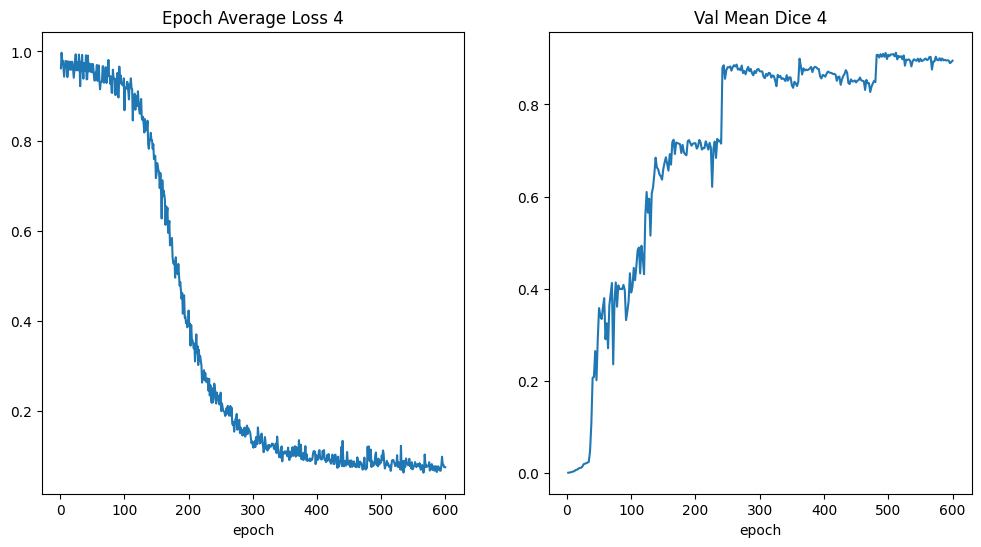

In [25]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Epoch Average Loss {i}")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title(f"Val Mean Dice {i}")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Model Evaluation

In [26]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [52]:
test_ds = CacheDataset(data=test_data, transform=val_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=4)

Loading dataset: 100%|██████████| 562/562 [00:00<00:00, 1314.27it/s]


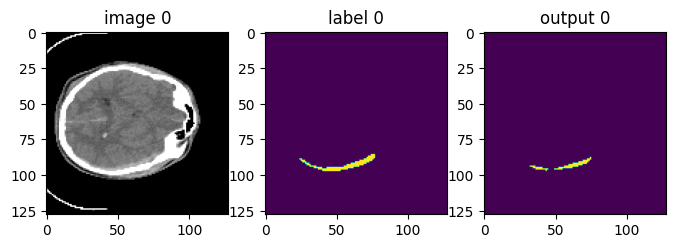

In [63]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        roi_size = (128, 128)
        sw_batch_size = 4
        val_outputs = model(val_data["image"].to(device))

        val_outputs = (val_outputs > 0.5).float()

        if np.sum(val_data["label"]) > 10:
            for j in range(val_outputs.shape[0]):
                if np.sum(val_data["label"][j]) > 0:

                    plt.figure("check", (8,6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    plt.imshow(val_data["image"][j, 0, :, :], cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    plt.imshow(val_data["label"][j, 0, :, :])
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")
                    plt.imshow(val_outputs.detach().cpu()[j, 0, :, :])
                    plt.show()
        break

In [49]:
model.eval()
val_iou = []
with torch.no_grad():
    for i in range(len(test_data)):
        # get the image and label
        image, label = test_data[i]["image"], test_data[i]["label"]

        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label)
        image = image.unsqueeze(0)
        label = label.unsqueeze(0)
        # print(image.shape)
        # print(label.shape)
        # get the prediction
        pred = model(image.to(device))
        # get the prediction mask
        pred_mask = (pred > 0.5).float().detach().cpu()
        # print(pred_mask.shape)

        # Calculate IoU for the batch
        intersection = torch.sum(pred_mask * label)
        union = torch.sum(label) + torch.sum(pred_mask) - intersection
        iou = (intersection + 1e-15) / (union + 1e-15)
        val_iou.append(iou.item())

In [50]:
print("Average IoU score on testing set")
sum(val_iou)/len(val_iou)

Average IoU score on testing set


0.921000449629865